In [1]:
import sys

preprocessing_path = 'C:\\Users\\joshh\\Desktop\\Uni\\Soton Uni - Yr 3\\COMP3200\\fake-news-profiling\\classifier\\preprocessing'
if preprocessing_path not in sys.path:
    sys.path.insert(1, preprocessing_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
import string
from xml.sax.saxutils import unescape
import demoji
import numpy as np
from bs4 import BeautifulSoup
from unidecode import unidecode

from nltk.corpus import stopwords
from wordcloud import WordCloud
from colour import Color

import ipynb.fs.full.parse_datasets as datasets

# Parse the dataset

In [12]:
# Load the saved dataset split
def load_data():
    return np.load("datasets/en_split_data.npy", allow_pickle=True)

(tweet_train, label_train, 
 tweet_val, label_val, 
 tweet_test, label_test) = load_data()

In [15]:
data = datasets.parse_dataset("datasets", "en", to_pandas=True)
data = data[data["author_id"].isin([user[0].username for user in tweet_train])]
truthful_tweets = data.loc[data['truth_value'] == '0'].iloc[:, 2:].values.flatten()
fake_tweets = data.loc[data['truth_value'] == '1'].iloc[:, 2:].values.flatten()

print("Number of truthful users:", int(len(truthful_tweets)/100))
print("Number of fake users:", int(len(fake_tweets)/100))

Number of truthful users: 120
Number of fake users: 120


In [17]:
data.head()

,author_id,truth_value,tweet_1,tweet_2,tweet_3,tweet_4,tweet_5,tweet_6,tweet_7,tweet_8,...,tweet_91,tweet_92,tweet_93,tweet_94,tweet_95,tweet_96,tweet_97,tweet_98,tweet_99,tweet_100
0,06ct0t68y1acizh9eow3g5rhancrppr8,1,Courteney Cox Recreates Classic Friends Scene ...,The Jonas Brothers Have Secret Concert Days Af...,Ariana Grande Sends Heartfelt Message to Her F...,7 of the Biggest Bombshells From Jordyn Woods'...,Fyre Festival's Andy King Spills New Details o...,Watch Travis Scott Take an Adorable Phone Call...,See What Tyler Henry Really Thinks About His K...,Kim Kardashian Says She Had ''One of the Best ...,...,It's Pauly D Like You've Never Seen Him Before...,Hailey Baldwin Sends Her ''Lover'' Justin Bieb...,You Won't Believe How Much Money Property Brot...,"You Have to See Nicki Minaj's $450,000 Rolls-R...",How Maddie Poppe and Caleb Lee Hutchinson Are ...,What Do the Kids of the Grey's Anatomy Cast Th...,Inside Nikki Bella's Romantic Date Night With ...,How Justin Bieber Celebrated His 25th Birthday...,Matthew McConaughey's 3 Stylish Kids Make a Ra...,Royal Bartender! Kate Middleton Pours a Pint o...
1,071nxc49ihpd0jlfmvn2lghtayy3b5n9,0,Amber Smith “Kandy Halloween: Return of the Ha...,Kourtney Kardashian Reveals Scott Disick 'Chec...,Serena Williams Steps Out at the 2019 Met Gala...,See the campiest looks from 2019 Met Gala pink...,Trouble in Paradise? Kris Jenner and Corey Gam...,Bethenny Frankel Wants To Sell SkinnyGirl Beca...,Everything Kim Kardashian Has Said About Surro...,Kim Kardashian Confirms 4th Baby Not Here Yet ...,...,Michelle Williams Fuels Reconciliation Rumors ...,Dream Kardashian Flaunts Her Long Curly Locks ...,Charlize Theron Finally Addresses Her Rumored ...,Scott Disick Doesn’t Want To ‘Disrespect’ Sofi...,Kim Kardashian Lobbying for Systematic Change ...,Cardi B and Nicki Minaj Both Hit Met Gala Red ...,Jennifer Lopez and Alex Rodriguez Step Out for...,Jessie J Puts Her Misspelled Tattoo on Display...,Meghan Markle Gives Birth To Baby Boy! #URL#,Amy Schumer Cradles Up to Newborn Son Gene In ...
2,09py5qescynpnnckmzueqzr2y49moh1o,0,Rachel Bilson Was Asked Point-Blank if She’s D...,Bill Hader and Rachel Bilson make red carpet d...,What Do The Stars Say About Rachel Bilson? (12...,Celebrities front row at NYFW 2020 - Page Six ...,Rachel Bilson dating Bill Hader? - Arizona Dai...,Bill Hader and Rachel Bilson Confirm Relations...,How Did Rachel Bilson and Bill Hader Meet? - Y...,Rachel Bilson’s Golden Highlights Made For The...,...,Rachel Bilson On Helping La Marca Prosecco Lau...,Now This Is an Unexpected Couple - The Cut #UR...,"Love That O.C. Reunion Pic? Well, We've Got So...",Is Rachel Bilson Loved or Hated? New Analysis ...,Never Forget When Bill Hader Parodied Rachel B...,Bill Hader and Rachel Bilson made their red ca...,Rachel Bilson shops for home furnishings and g...,"Hold Up, Are Rachel Bilson and Bill Hader a Co...","Bill Hader, Rachel Bilson continue to fuel rum...",New couple alert! Bill Hader takes Rachel Bils...
3,0dwovd7nj6yg9m795ng2c629me0ccmrh,0,RT #USER#: The Public Relations Officer For Zo...,Supreme Court Nullifies APC’s Victory In The B...,"RT #USER#: Great Tension In #USER#, As Supreme...",RT #USER#: Some Evil Politicians Hired And Pai...,"RT #USER#: Presidency Raises Alarm, Accuses #U...",RT #USER#: Supreme Court Nullifies #USER#’s Vi...,"$308 Million Abacha Loot!!! America Blows Hot,...",RT #USER#: Bayelsa!!! #USER# Defends Recent Su...,...,Suspected APC Supporters Unleash Violence In B...,RT #USER#: Oshiomhole Ordered To Resign As APC...,RT #USER#: The Director Of Public Relations An...,"RT #USER#: Adams Oshiomhole, The New Chief Jus...","RT #USER#: The #USER#, Has On Friday, Announce...",RT #USER#: Be To Combat Criminals In The South...,"RT #USER#: Tears, As #USER# Receives News Of H...",RT #USER#: INEC To Go Back To Its Operations D...,"Trouble, As Boko Haram Rejects The Payment Of ...","RT #USER#: #HASHTAG#: An Official Of #USER#, E..."
4,0ibi364m7i7l01xi4xqafyathrmrrnll,

# Helper functions

In [18]:
digits = set("0123456789")
printable = set(string.printable)
punctuation = set(string.punctuation)
punctuation.remove('#')

In [19]:
def clean_text(text, remove_punc=True, remove_non_print=True, remove_emojis=True, 
              remove_digits=True, remove_tags=False):
    """ Clean text by removing certain characters (e.g. punctuation) """
    if remove_emojis:
        text = demoji.replace(text, "")
        
    chars = []
    for char in text:
        if not ((remove_punc and char in punctuation) or
            (remove_non_print and char not in printable) or
            (remove_digits and char in digits)):
            chars.append(char)
        
    cleaned = "".join(chars)
    if remove_tags:
        return re.sub('#[A-Z]+#', "", cleaned)
    
    return cleaned

# Tweet lengths

## Number of characters used in tweets, per user
* Count the number of characters in a users 100 tweets and then take the mean and median

In [20]:
def tweet_lengths_per_user(data_array):
    """ Returns a Numpy array of average and median tweet lengths (in chars) for each user """
    char_lens = np.asarray([
        [len(tweet) for tweet in user_tweets]
        for user_tweets in data_array
    ])
    means = np.asarray([np.mean(tweet_lens) for tweet_lens in char_lens])
    medians = np.asarray([np.median(tweet_lens) for tweet_lens in char_lens])
    return means, medians

Average tweet lengths (in characters)


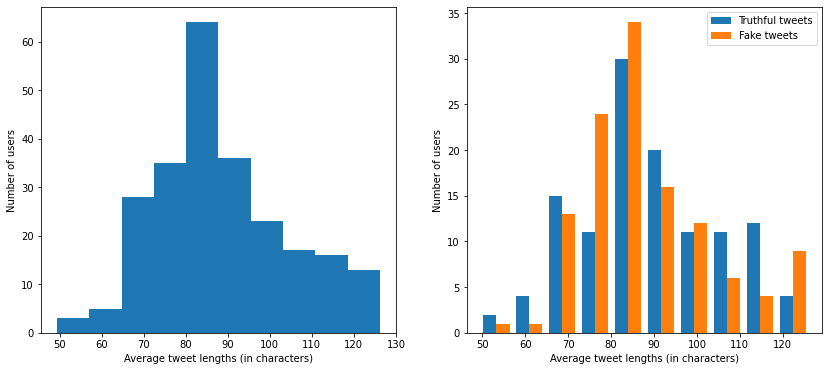

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

data_lens = tweet_lengths_per_user(data.iloc[:, 2:].values)
truthful_lens = tweet_lengths_per_user(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_lens = tweet_lengths_per_user(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

# All tweets plot
ax[0].hist(data_lens[0])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Average tweet lengths (in characters)")

# Truth label plot
ax[1].hist((truthful_lens[0], fake_lens[0]), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Average tweet lengths (in characters)")
ax[1].legend()
print("Average tweet lengths (in characters)")

Median tweet lengths (in characters)


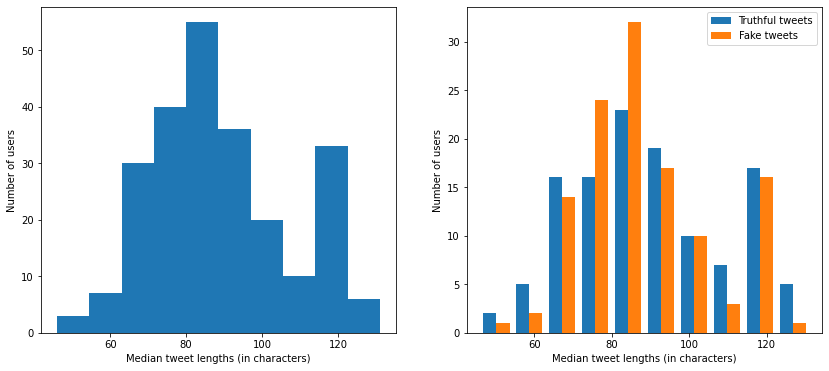

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

# All tweets plot
ax[0].hist(data_lens[1])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Median tweet lengths (in characters)")

# Truth label plot
ax[1].hist((truthful_lens[1], fake_lens[1]), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Median tweet lengths (in characters)")
ax[1].legend()
print("Median tweet lengths (in characters)")

Findings:
* Truthful users are more likely to write very short tweets
* On average fake users write the longest tweets, but medians show that truthful users are more likely to have higher tweet 
  medians
* Fake users write mid-length tweets than truthful users

## Number of words used in tweets, per user
* Count the number of words in a users 100 tweets and then take the mean and median

In [24]:
def remove_punc(text):
    """ Removes all punctuation from some text (excluding hashtags '#') """
    punc = set(string.punctuation)
    prin = set(string.printable)
    punc.remove("#")
    return "".join(c.lower() for c in text if c not in punc and c in prin)

def tweets_to_words(data_array):
    """ Returns a Numpy array where tweets have been split by spaces (after removing punctuation) """
    return np.asarray([
        [remove_punc(tweet).split(" ") for tweet in user_tweets] 
        for user_tweets in data_array
    ])

Average tweet lengths (in words)


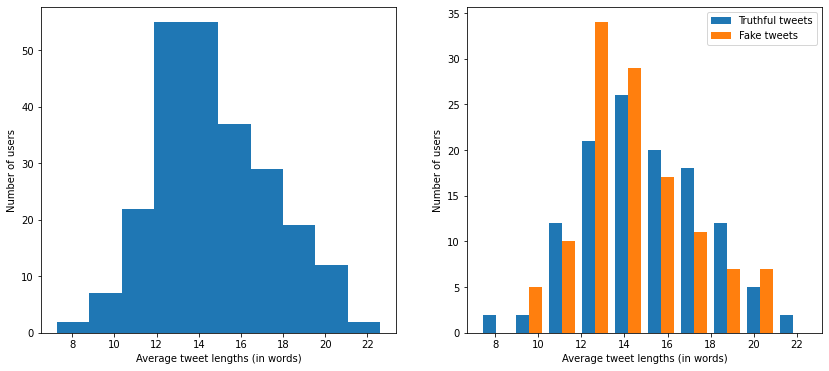

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

data_lens = tweet_lengths_per_user(
    tweets_to_words(data.iloc[:, 2:].values))
truthful_lens = tweet_lengths_per_user(
    tweets_to_words(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values))
fake_lens = tweet_lengths_per_user(
    tweets_to_words(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values))

# All tweets plot
ax[0].hist(data_lens[0])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Average tweet lengths (in words)")

# Truth label plot
ax[1].hist((truthful_lens[0], fake_lens[0]), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Average tweet lengths (in words)")
ax[1].legend()
print("Average tweet lengths (in words)")

Median tweet lengths (in words)


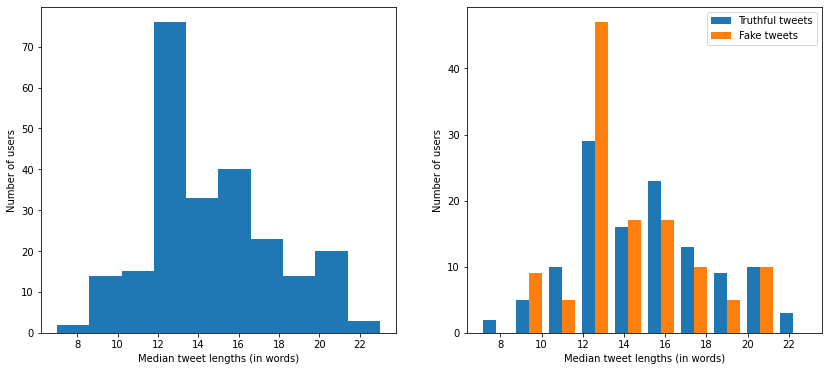

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

# All tweets plot
ax[0].hist(data_lens[1])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Median tweet lengths (in words)")

# Truth label plot
ax[1].hist((truthful_lens[1], fake_lens[1]), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Median tweet lengths (in words)")
ax[1].legend()
print("Median tweet lengths (in words)")

Findings:
* Truthful users typically use the fewest words or the most words in tweets - shown in both mean and medians
* Similar to with char lengths, fake users normally use mid-length tweets (when measuring length by words)

## Word lengths of users
* Count the lengths of all words used by a user, and then take the mean and median

Findings:
* Fake news authors use (on average) longer words, while truthful authors use shorter words

In [27]:
def tweets_to_flattened_words(data_array):
    """ Returns a Numpy array where tweets have been split by spaces (after removing punctuation) and flattened """
    return np.asarray([
        [word for tweet in user_tweets for word in remove_punc(tweet).split()] 
        for user_tweets in data_array
    ])

Average word lengths


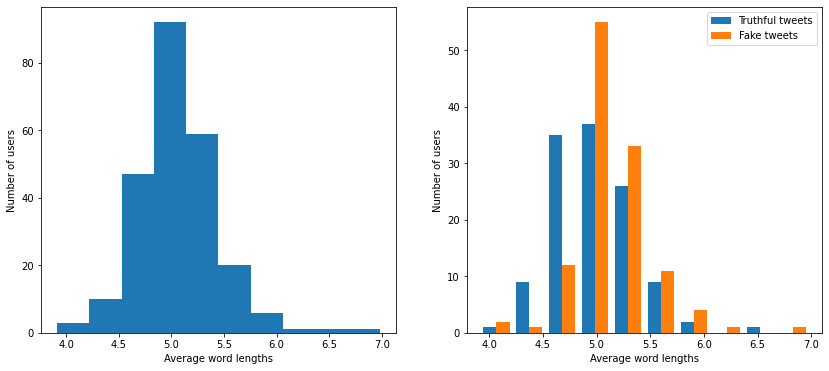

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

data_lens = tweet_lengths_per_user(
    tweets_to_flattened_words(data.iloc[:, 2:].values))
truthful_lens = tweet_lengths_per_user(
    tweets_to_flattened_words(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values))
fake_lens = tweet_lengths_per_user(
    tweets_to_flattened_words(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values))

# All tweets plot
ax[0].hist(data_lens[0])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Average word lengths")

# Truth label plot
ax[1].hist((truthful_lens[0], fake_lens[0]), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Average word lengths")
ax[1].legend()
print("Average word lengths")

Median word lengths


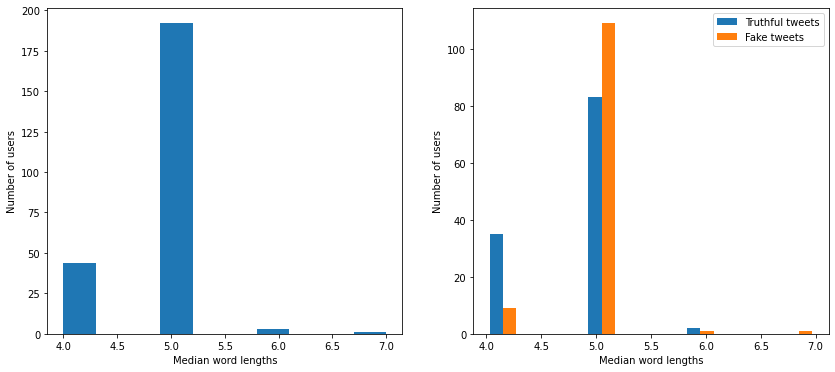

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

# All tweets plot
ax[0].hist(data_lens[1])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Median word lengths")

# Truth label plot
ax[1].hist((truthful_lens[1], fake_lens[1]), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Median word lengths")
ax[1].legend()
print("Median word lengths")

Findings:
* Truthful users use shorter words
* Fake users use longer words

# Types of words used

## Frequent words

In [30]:
def tweets_to_word_freq(tweets_data_array):
    """ Returns a dict of words mapped to their frequency (ignoring stopwords) """
    word_freq = dict()
    english_stopwords = set([remove_punc(word) for word in stopwords.words('english')])

    for word in [word for tweet in tweets_data_array for word in remove_punc(tweet).split(" ")]:
        if word not in english_stopwords:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    
    return word_freq

In [31]:
# Wordcloud data
data_freq = tweets_to_word_freq(data.iloc[:, 2:].values.flatten())
truthful_freq = tweets_to_word_freq(truthful_tweets)
fake_freq = tweets_to_word_freq(fake_tweets)

color_map = dict()
for k, v in truthful_freq.items():
    other_v = fake_freq[k] if k in fake_freq else 0
    color_map[k] = v/(v+other_v)

def color_map_func(word, **kwargs):
    color_val = color_map[word] if word in color_map else 0
    return Color(rgb=(1-color_val, color_val, 0)).hex

Wordclouds of frequent words


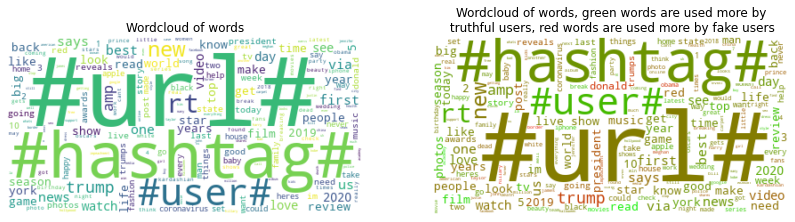

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 8))

wc = WordCloud(background_color="white")
wc.fit_words(data_freq)
ax[0].imshow(wc, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title("Wordcloud of words")

wc = WordCloud(background_color="white", color_func=color_map_func)
wc.fit_words(data_freq)
ax[1].imshow(wc, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title("Wordcloud of words, green words are used more by\n truthful users, red words are used more by fake users")

print("Wordclouds of frequent words")

Findings:
* The most-used words are tagrs (url, hashtag, user, rt)
* User tags seem to be used mostly by truthful users
* 'donald', 'trump', 'obama', 'hillary' seem to be the words most used primarily by fake users

How could I use this?
* Counting the different tags for each user and passing them into a model
* We cannot count raw words like 'trump' or 'obama' as this would limit the future potential of our model. Instead it may be possible to use a remote political API to count usage of political terms instead

## Use of tags

In [33]:
def count_term_in_tweets(tweets_array, term):
    count = [tweet.count(term) for tweet in tweets_array]
    return (sum(count), np.mean(count), np.median(count))

def tweets_to_tag_freq_per_user(data_array):
    return [
        {
            'RT': np.asarray(count_term_in_tweets(user_tweets, 'RT')),
            '#USER#': np.asarray(count_term_in_tweets(user_tweets, '#USER#')),
            '#HASHTAG#': np.asarray(count_term_in_tweets(user_tweets, '#HASHTAG#')),
            '#URL#': np.asarray(count_term_in_tweets(user_tweets, '#URL#')),
        } 
        for user_tweets in data_array
    ]

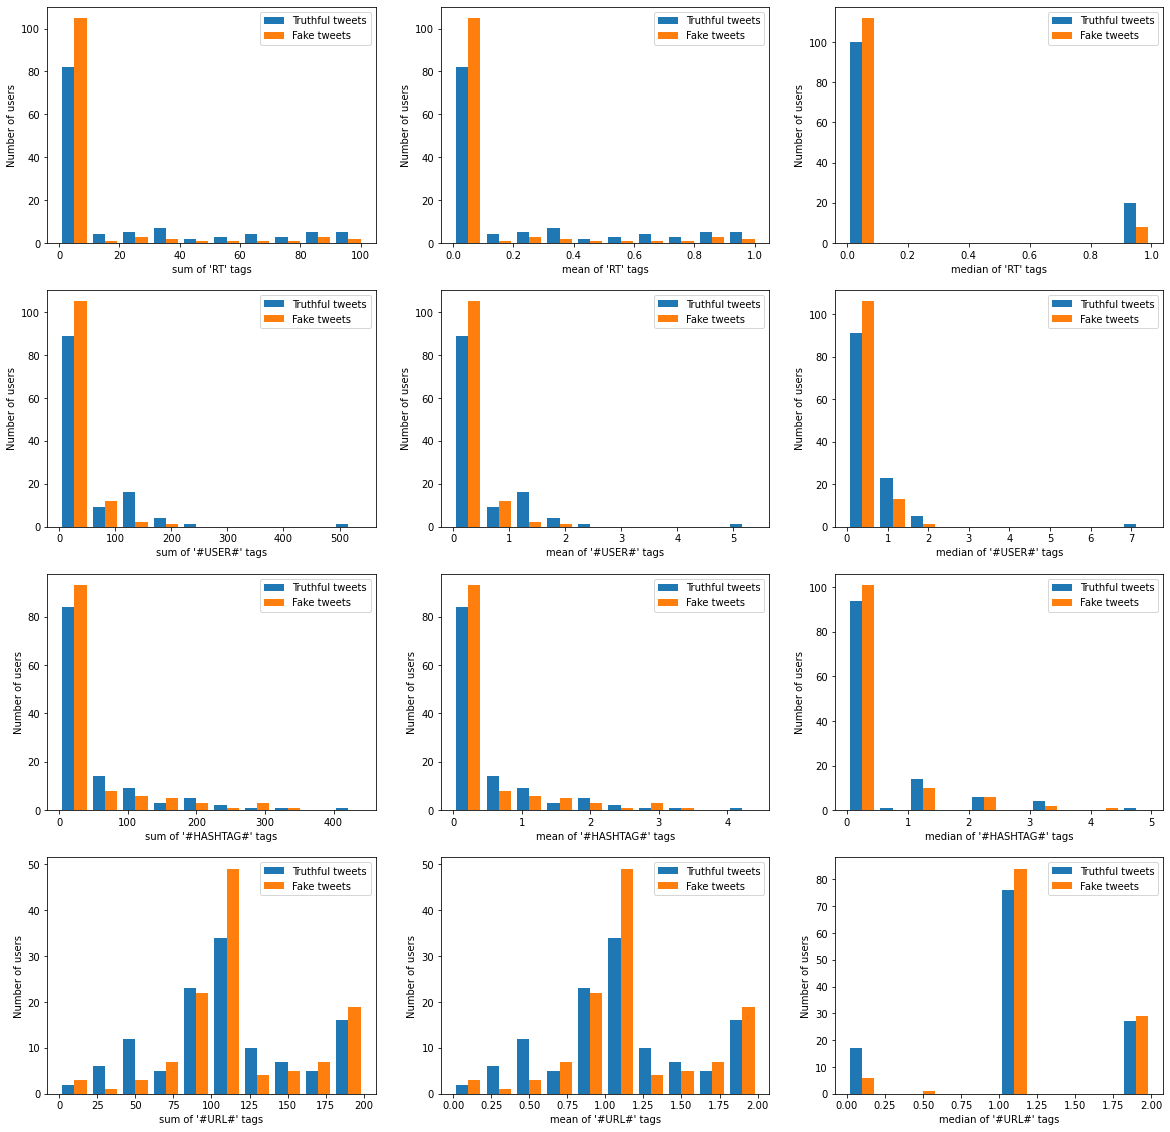

In [34]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))

tags = ['RT', '#USER#', '#HASHTAG#', '#URL#']
truthful_terms = tweets_to_tag_freq_per_user(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_terms = tweets_to_tag_freq_per_user(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

# Truth label plots
for row, tag in enumerate(tags):
    truthful_hist_data = np.asarray([user[tag] for user in truthful_terms])
    fake_hist_data = np.asarray([user[tag] for user in fake_terms])
    
    for col in range(3):  
        ax[row][col].hist(
            (truthful_hist_data[:, col], fake_hist_data[:, col]),
            label=("Truthful tweets", "Fake tweets"))
        ax[row][col].set_ylabel("Number of users")
        ax[row][col].set_xlabel(f"{'sum' if col == 0 else ('mean' if col == 1 else 'median')} of '{tag}' tags")
        ax[row][col].legend()

Findings:
* Fake users seem to use fewer RT, #USER#, and #HASHTAG# tags
* However, they generally use more #URL# tags

How could I use this?
* Count mean and medians of these terms and push them through a basic Logistic Regression model, or create some user embeddings using them to push through a more complex model

# Types of characters used

## Letter casing
* Look at the average letter casing of users

In [35]:
def average_char_casing_per_user(data_array):
    """ Returns Numpy arrays of the average character casings (uncased/lowercase and cased/uppercase) """
    uncased = [
        np.mean([sum([c.islower() for c in tweet]) for tweet in user_tweets]) 
        for user_tweets in data_array
    ]
    cased = [
        np.mean([sum([c.isupper() for c in tweet]) for tweet in user_tweets]) 
        for user_tweets in data_array
    ]
    return uncased, cased

Average user character casing


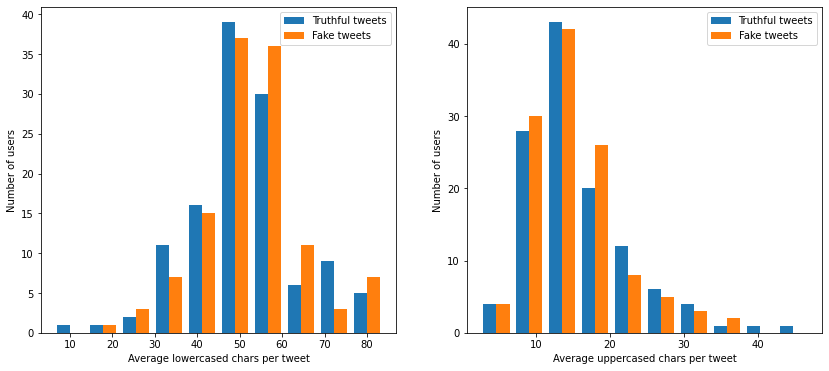

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

truthful_casing = average_char_casing_per_user(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_casing = average_char_casing_per_user(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

# Uncased
ax[0].hist((truthful_casing[0], fake_casing[0]), label=("Truthful tweets", "Fake tweets"))
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Average lowercased chars per tweet")
ax[0].legend()

# Cased
ax[1].hist((truthful_casing[1], fake_casing[1]), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Average uppercased chars per tweet")
ax[1].legend()
print("Average user character casing")

## Use of emojis

In [37]:
def count_emojis(user_tweets):
    count = 0
    for tweet in user_tweets:
        emojis_found = list(demoji.findall(tweet).keys())
        for emoji in emojis_found:
            count += len(re.findall(emoji, tweet))
    
    return count

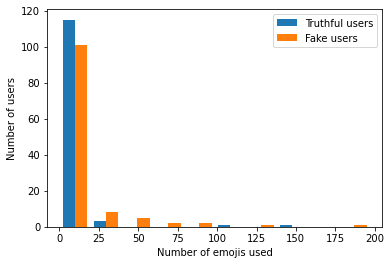

In [38]:
truthful_tweets_per_user = data.loc[data['truth_value'] == '1'].iloc[:, 2:].values
fake_tweets_per_user = data.loc[data['truth_value'] == '0'].iloc[:, 2:].values

truthful_emojis = [count_emojis(user_tweets) for user_tweets in truthful_tweets_per_user]
fake_emojis = [count_emojis(user_tweets) for user_tweets in fake_tweets_per_user]
plt.hist((truthful_emojis, fake_emojis), label=("Truthful users", "Fake users"))
plt.xlabel("Number of emojis used")
plt.ylabel("Number of users")
plt.legend()

## Use of punctuation

In [39]:
def average_punc_per_user(data_array):#
    """ Returns Numpy array of the average amount of punctuation used """
    punc = set(string.punctuation)
    punc.remove('#')
    return np.asarray([
        np.mean([sum([c in punc for c in tweet]) for tweet in user_tweets]) 
        for user_tweets in data_array
    ])

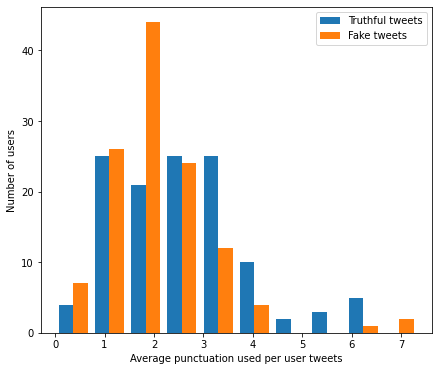

In [40]:
fig, ax = plt.subplots(ncols=1, figsize=(7, 6))

truthful_punc = average_punc_per_user(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_punc = average_punc_per_user(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

# Punctuation
ax.hist((truthful_punc, fake_punc), label=("Truthful tweets", "Fake tweets"))
ax.set_ylabel("Number of users")
ax.set_xlabel("Average punctuation used per user tweets")
ax.legend()

# Sentiment
* Look at average sentiment per user

According to vaderSentiment:
* positive sentiment: compound score >= 0.05
* neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
* negative sentiment: compound score <= -0.05

In [41]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

In [42]:
def polarity_scores(text, analyzer):
    polarity_dict = analyzer.polarity_scores(text)
    return np.asarray([
        polarity_dict['pos'],
        polarity_dict['neu'],
        polarity_dict['neg'],
        polarity_dict['compound'],
    ])

def average_sentiment_per_user(data_array):
    """ Returns Numpy array of the average sentiment of each user; 
    Returned sentiment is an array of [positive, neural, negative, compound] """
    analyzer = SentimentIntensityAnalyzer()
    return np.asarray([
        np.mean([polarity_scores(tweet, analyzer) for tweet in user_tweets], axis=0) 
        for user_tweets in data_array
    ])

Text(0.5, 0, 'Average compound sentiment')

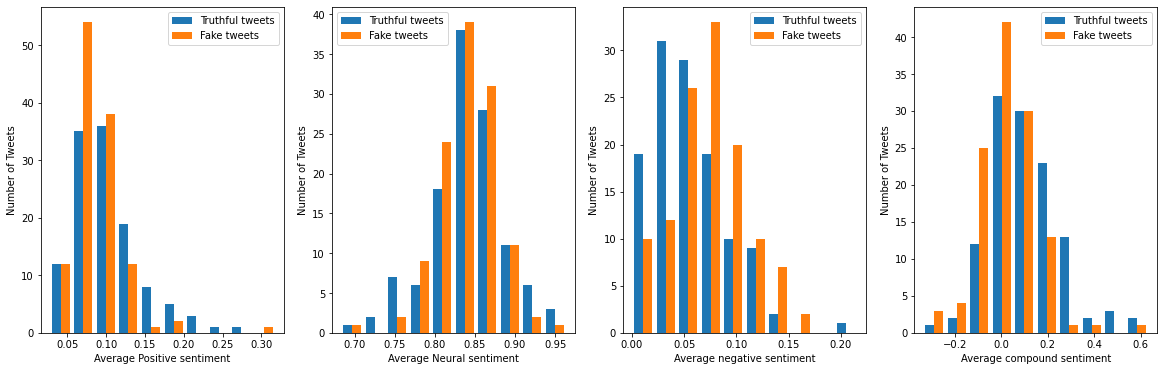

In [43]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 6))

truthful_sentiment = average_sentiment_per_user(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_sentiment = average_sentiment_per_user(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

for col in range(4):
    ax[col].hist((truthful_sentiment[:, col], fake_sentiment[:, col]), label=("Truthful tweets", "Fake tweets"))
    ax[col].set_ylabel("Number of Tweets")
    ax[col].legend()
    
ax[0].set_xlabel("Average Positive sentiment")
ax[1].set_xlabel("Average Neural sentiment")
ax[2].set_xlabel("Average negative sentiment")
ax[3].set_xlabel("Average compound sentiment")

In [44]:
# Plot average sentiment of truthful tweets compared to fake tweets
def average_compound_scores(data_array):
    return np.mean([
        [sentiment_analyzer.polarity_scores(tweet)['compound'] for tweet in user_tweets] 
        for user_tweets in data_array
    ], axis=0)

truthful_average_sentiment = average_compound_scores(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_average_sentiment = average_compound_scores(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

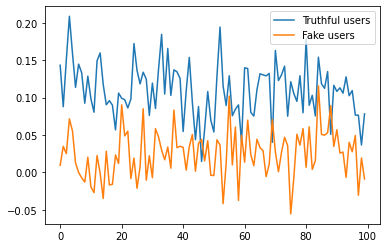

In [51]:
plt.plot(truthful_average_sentiment, label="Truthful users")
plt.plot(fake_average_sentiment, label="Fake users")
plt.legend()

In [47]:
# Get the overall sentiment of each users tweets
def all_tweet_compound_scores(data_array):
    return [
        sentiment_analyzer.polarity_scores(" ".join(user_tweets))['compound']
        for user_tweets in data_array
    ]

truthful_total_sentiment = all_tweet_compound_scores(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_total_sentiment = all_tweet_compound_scores(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

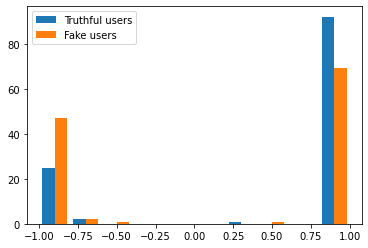

In [48]:
plt.hist((truthful_total_sentiment, fake_total_sentiment), label=("Truthful users", "Fake users"))
plt.legend()

Findings:
* Fake users have higher negative sentiment than truthful users
* Higher positive sentiments are normally truthful users

## Sentiment box plot of a user

In [49]:
import seaborn as sb

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
user_tweets = data.iloc[0, 2:].values.flatten()
user_tweets_sent = [sentiment_analyser.polarity_scores(tweet)['compound'] for tweet in user_tweets]

In [ ]:
bp = sb.boxplot(x=user_tweets_sent,
               showmeans=True,
               whiskerprops=dict(color="#007bff"),
               flierprops=dict(color="#a600ff"),
               medianprops=dict(color="#a600ff"),
               meanprops=dict(
                   marker='H',
                   markeredgecolor='#42f590',
                   markerfacecolor='#42f590',
                   markersize=12,),
               boxprops=dict(color="#007bff"),
               capprops=dict(color="#a600ff"),
               )
sb.swarmplot(x=user_tweets_sent, color=".2")

# Readability
* Using the Automated Readability Index - https://en.wikipedia.org/wiki/Automated_readability_index

In [ ]:
import textstat

In [ ]:
def average_automated_readability_index(data_array):
    """ Returns Numpy array of the average Automated Readability Index of each user """
    return np.asarray([
        np.mean([textstat.automated_readability_index(tweet) for tweet in user_tweets], axis=0) 
        for user_tweets in data_array
    ])

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

truthful_readability = average_automated_readability_index(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_readability = average_automated_readability_index(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

# Uncased
ax[0].hist((truthful_readability, fake_readability), label=("Truthful tweets", "Fake tweets"))
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Automated Readability Index")
ax[0].legend()

# Named Entity Recognition
* Use Spacy to extract named entities from tweets

In [ ]:
import spacy
spacy_nlp = spacy.load("en_core_web_sm")

In [ ]:
def extract_named_entities(data_array):
    """ Returns Numpy array of the named entities used in each users tweets """
    return np.asarray([
        np.asarray([spacy_nlp(clean_text(tweet, remove_tags=True)).ents for tweet in user_tweets])
        for user_tweets in data_array
    ])

In [ ]:
truthful_entities = extract_named_entities(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_entities = extract_named_entities(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

truthful_entities_count = [np.sum([len(entities) for entities in user]) for user in truthful_entities]
fake_entities_count = [np.sum([len(entities) for entities in user]) for user in fake_entities]

# Uncased
ax[0].hist((truthful_entities_count, fake_entities_count), label=("Truthful tweets", "Fake tweets"))
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Total count of named entities used by the user")
ax[0].legend()

In [ ]:
spacy_entity_labels = ["PERSON", "NORP", "FAC", "ORG", "GPE", "LOC", "PRODUCT", "EVENT", "WORK_OF_ART", "LAW", "LANGUAGE",
                      "DATE", "TIME", "PERCENT", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL"]

for label in spacy_entity_labels:
    tc = np.mean([np.sum([np.sum([1 if e.label_ == label else 0 for e in entities]) for entities in user]) 
          for user in truthful_entities])
    fc = np.mean([np.sum([np.sum([1 if e.label_ == label else 0 for e in entities]) for entities in user]) 
          for user in fake_entities])
    print(f"Label: {label} - Truthful {tc} - Fake {fc}")

Findings:
* Fake news spreaders (on average) refer to named persons more (PERSON), and to nationalities, religions and political groups (NORP). They also mention geo-political entities (such as countries) more (GPE).
* Truthful users seem to refer to dates (DATE) and time (TIME) more.